In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import h5py
from astropy.io import fits
from astropy.convolution import Gaussian1DKernel, convolve
from scipy import interpolate

In [2]:
source_name = 'hydra'

In [3]:
# Directory path where your files are located
directory_path = 'ATCA_HI_spectra/Hydra'

# Common part of the filename
common_part_v4 = '_cube_4k_atca_4k_spectrum.txt'
# Common part of the filename
common_part_v2 = '_cube_v2_atca_spectrum.txt'

# List all files in the directory
all_files = os.listdir(directory_path)

# Filter files based on the common part of the filename
files_spectra_v4 = [file for file in all_files if common_part_v4 in file]

# Filter files based on the common part of the filename
files_spectra_v2 = [file for file in all_files if common_part_v2 in file]

In [4]:
def plot_spectra(files_spectra, image_name, source = None):
    # Calculate the number of rows and columns for subplots
    num_files = len(files_spectra)
    num_rows = int(np.ceil(num_files / 3))  # 2 subplots per row

    # Create a single figure with multiple subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(16, 6*num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Iterate through matching files and create subplots for each file
    for i, file_name in enumerate(files_spectra):
        # Construct the full file path
        file_path = os.path.join(directory_path, file_name)

        # Read data from the text file into a NumPy array, skipping the header row
        data = np.loadtxt(file_path, skiprows=1)

        # Extract velocity and amplitude columns
        velocity = data[:, 1]
        amplitude = data[:, 2]
        
        #Mask signal channels
        rms_spect = np.sqrt(np.mean(amplitude**2))
        spectrum = np.copy(amplitude)
        spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect
        y = spectrum
        x = velocity
        pars = np.polyfit(x, y, 1)
        p = np.poly1d(pars)
        tauhi = amplitude/p(x)
        tauhi = np.array(tauhi)
        rms = np.std(tauhi)
        
        #Smoothing    
        g = Gaussian1DKernel(0.7)
        hismooth = convolve(amplitude, g, boundary='extend')
        tauhi_smooth = hismooth/p(x)
        rms_smooth = np.std(tauhi_smooth)
 
        # Tau
        tau_smooth = np.log(tauhi_smooth)*(-1)
        tau = np.log(tauhi)*(-1)
        
        # Plot velocity vs amplitude for each file in a subplot
        
        axes[i].plot(x, tau, linestyle='-', linewidth=1, color='orange', label='Signal')
        axes[i].plot(x, tau_smooth, linestyle='-', linewidth=1, color='g', label='Smoothed')
        
        axes[i].axhspan(-rms, + rms, alpha=0.2, color='grey')
        axes[i].axhline(0, color='k', linestyle='--', linewidth=2)
        #axes[i].axhspan(-rms_smooth, + rms_smooth, alpha=0.2, color='C3')
        
        axes[i].set_xlabel('v[Km/s]', fontsize=15)
        #axes[i].set_ylabel(r'e$^{-\tau}$', fontsize=15)
        axes[i].set_ylabel(r'${\tau}$', fontsize=15)
        
        axes[i].set_title(f'File: {file_name}')
        axes[i].grid(True)
        
        # Add legend
        axes[i].legend()

    # Hide any remaining empty subplots, if any
    for j in range(num_files, num_rows*3):
        fig.delaxes(axes[j])

    # Adjust layout and display the figure
    plt.tight_layout()
    if image_name is not None:
        # Ensure the output directory exists
        output_dir = os.path.join('Images', source)  #Change Norma or Hydra
        os.makedirs(output_dir, exist_ok=True)

        # Save the figure
        output_path = os.path.join(output_dir, f'{image_name}.png')
        plt.savefig(output_path)
    
    plt.show()

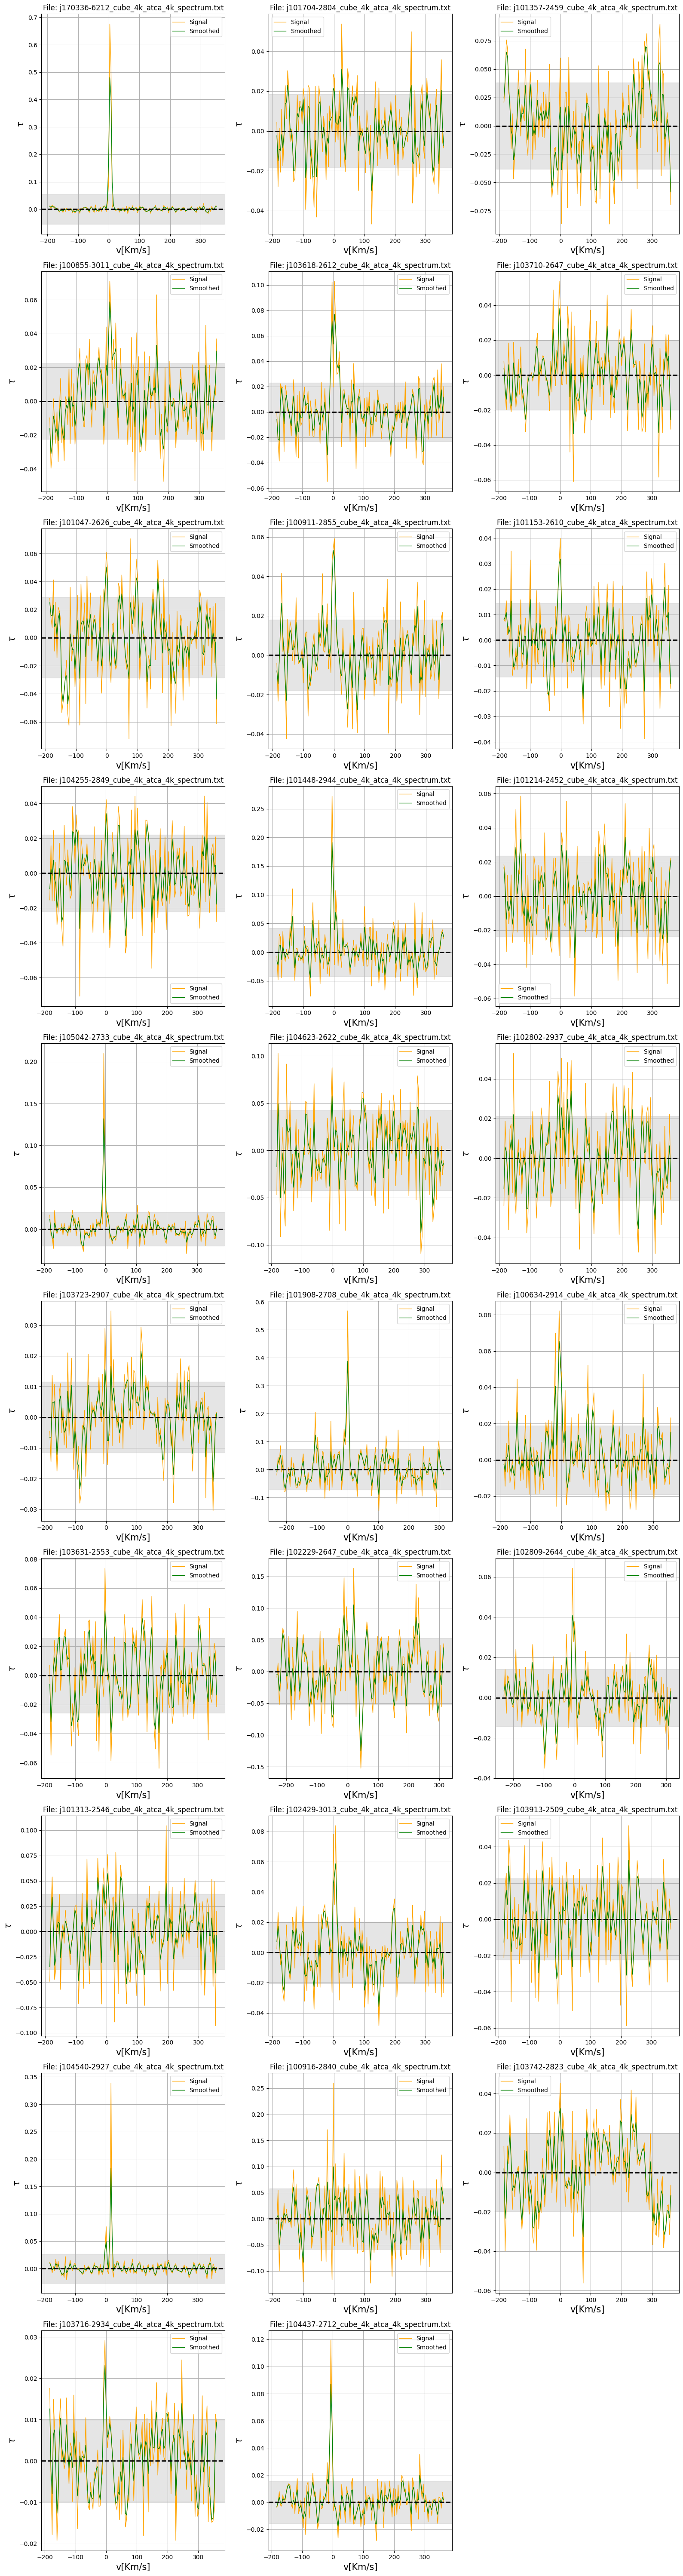

In [5]:
plot_spectra(files_spectra_v4,'spectra_4k_tau',source_name)

/tmp/ipykernel_282/1098800726.py:42: RuntimeWarning: invalid value encountered in log
  tau = np.log(tauhi)*(-1)


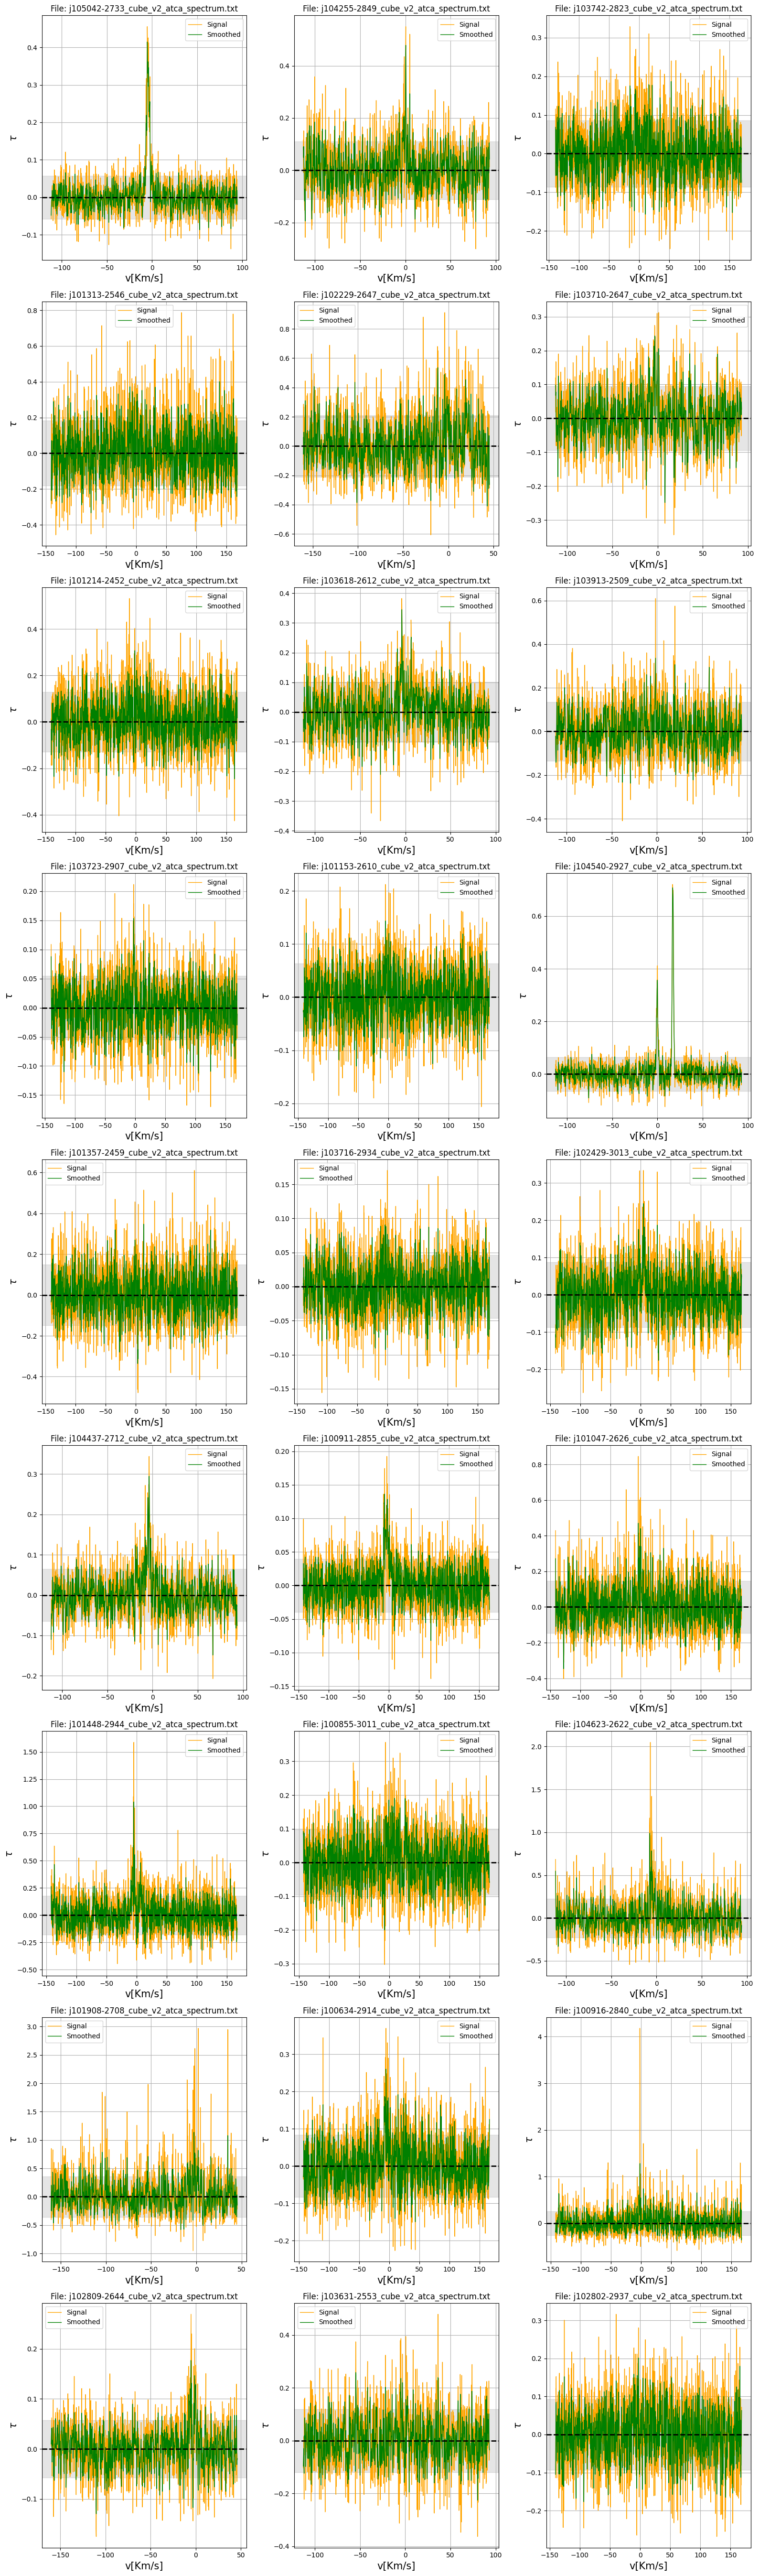

In [6]:
plot_spectra(files_spectra_v2,'spectra_v2_tau',source_name)

In [7]:
def grid_dimensions(N):
    factors = []
    for i in range(1, int(math.sqrt(N)) + 1):
        if N % i == 0:
            factors.append((i, N // i))    
    # Choose the factors that make the grid closest to a square
    m, n = min(factors, key=lambda x: abs(x[0] - x[1]))
    return m,n

In [8]:
def get_nans(array_cube):
    nan_mask_3d = np.isnan(array_cube)

    # Get the indices of NaN values
    nan_indices_3d = np.where(nan_mask_3d)

    print(nan_indices_3d)

In [9]:
a, b = grid_dimensions(len(files_spectra_v4)+1)
print(a, b)

5 6


In [10]:
print(len(files_spectra_v4))
print(len(files_spectra_v2))

29
27


In [11]:
atca_spect_4k = np.zeros((140, a, b))     #Resolution of 4 km/s

### 4 km/s resolution

In [12]:
for i, file_name in enumerate(files_spectra_v4):
    # Construct the full file path
    file_path = os.path.join(directory_path, file_name)
    
    # Read data from the text file into a NumPy array, skipping the header row
    data = np.loadtxt(file_path, skiprows=1)
    
    # Extract velocity and amplitude columns
    velocity = data[:, 1]
    amplitude = data[:, 2]
    rms_spect = np.sqrt(np.mean(amplitude**2))
    spectrum = np.copy(amplitude)
    
    #Mask signals
    spectrum[spectrum < rms_spect - (np.max(spectrum) - rms_spect)] = rms_spect  
    
    if i == 0:
        crval3_4k = velocity[0]
    y = spectrum
    x = velocity 
    pars = np.polyfit(x, y, 1)
    p = np.poly1d(pars)    
    
    tauhi = amplitude/p(x)
    tauhi = np.array(tauhi)
    rms = np.std(tauhi)

    #Smoothing    
    g = Gaussian1DKernel(.7)
    hismooth = convolve(amplitude, g, boundary='extend')
    tauhi_smooth = hismooth/p(x)
    rms_smooth = np.std(tauhi_smooth)

    # Tau
    tau_smooth = np.log(tauhi_smooth)*(-1)
    #tau = np.log(tauhi)*(-1)


    # Calculate indices for atca_spect_v2
    index1 = i // b  # Row index
    index2 = i % b   # Column index
    
    # Assign tauhi values to atca_spect_v2 at specified indices
    atca_spect_4k[:,index1, index2] = tau_smooth


### 0.2 km/s resolution

In [13]:
atca_spect_v2_1000 = []
atca_spect_v2_1500 = []
for i, file_name in enumerate(files_spectra_v2):

    # Construct the full file path
    file_path = os.path.join(directory_path, file_name)
    
    # Read data from the text file into a NumPy array, skipping the header row
    data = np.loadtxt(file_path, skiprows=1)
    
    # Extract velocity and amplitude columns
    velocity = data[:, 1]
    amplitude = data[:, 2]
    rms_spect = np.sqrt(np.mean(amplitude**2))
    spectrum = np.copy(amplitude)
    spectrum[spectrum < rms_spect - (np.max(spectrum) - rms_spect)] = rms_spect

    y = spectrum
    x = velocity 
    pars = np.polyfit(x, y, 1)
    p = np.poly1d(pars)    
    
    tauhi = amplitude/p(x)
    tauhi = np.array(tauhi)
    rms = np.std(tauhi)

    #Smoothing    
    g = Gaussian1DKernel(1.)
    hismooth = convolve(amplitude, g, boundary='extend')
    tauhi_smooth = hismooth/p(x)
    rms_smooth = np.std(tauhi_smooth)

    # Tau
    tau_smooth = np.log(tauhi_smooth)*(-1)
    #tau = np.log(tauhi)*(-1) 
    if len(tau_smooth) != 1500:
        atca_spect_v2_1000.append(tau_smooth)
        if len(atca_spect_v2_1000) == 1:
            crval3_v2_1000 = velocity[0]     
    else:
        atca_spect_v2_1500.append(tau_smooth)
        if len(atca_spect_v2_1500) == 1:
            crval3_v2_1500 = velocity[0] 


In [14]:
print(len(atca_spect_v2_1500))
print(len(atca_spect_v2_1000))

15
12


In [15]:
array_1500 = np.zeros((len(atca_spect_v2_1500[0]),5, 3))
array_1000 = np.zeros((len(atca_spect_v2_1000[0]), 4, 3))

# Fill the NumPy arrays with data from the lists
for i, data in enumerate(atca_spect_v2_1500):
    index1 = i // 3  # Row index
    index2 = i % 3   # Column index
    array_1500[:, index1, index2] = data

for i, data in enumerate(atca_spect_v2_1000):
    index1 = i // 3  # Row index
    index2 = i % 3   # Column index
    array_1000[:, index1, index2] = data

In [16]:
# Function to interpolate NaNs
def interpolate_nans(arr):
    """
    Interpolate NaN values in a 2D array along the rows.
    
    Parameters:
    arr (ndarray): Input array with NaNs to interpolate.
    
    Returns:
    ndarray: Array with NaNs interpolated.
    """
    
    # Indices where NaNs are present
    nans = np.isnan(arr)
    # Indices where NaNs are not present
    x = np.arange(arr.shape[0])
    for i in range(arr.shape[1]):
        if np.any(nans[:, i]):
            valid = ~nans[:, i]
            arr[nans[:, i], i] = np.interp(x[nans[:, i]], x[valid], arr[valid, i])
    return arr


## Interpolatation

In [17]:
array_1500 = array_1500.reshape(1500, -1)

# Interpolate NaNs for each component
array_1500 = interpolate_nans(array_1500)

# Reshape back to the original shape 
array_1500 = array_1500.reshape(1500, 5, 3)

In [18]:
array_1000 = array_1000.reshape(1000, -1)

# Interpolate NaNs for each component
array_1000 = interpolate_nans(array_1000)

# Reshape back to the original shape 
array_1000 = array_1000.reshape(1000, 4, 3)

### Creation of FITS file

In [19]:
print("ATCA cube 1 for 0.2km: ", array_1500.shape)
print("ATCA cube 2 for 0.2km: ", array_1000.shape)
print("ATCA cube for 4km: ",atca_spect_4k.shape)

ATCA cube 1 for 0.2km:  (1500, 5, 3)
ATCA cube 2 for 0.2km:  (1000, 4, 3)
ATCA cube for 4km:  (140, 5, 6)


In [20]:
print(crval3_4k,
      crval3_v2_1000,
      crval3_v2_1500)

-192.245054387 -111.5981058 -138.952968077


In [21]:
def fits_cube(data_cube, CDELT3, CRVAL3, name, source):
    # Create a new FITS HDU object from the NumPy 
    hdu = fits.PrimaryHDU(data_cube)

    hdu.header['NAXIS'] = 3
    hdu.header['NAXIS1'] = data_cube.shape[1]
    hdu.header['NAXIS2'] = data_cube.shape[2]
    hdu.header['NAXIS3'] = data_cube.shape[0]


    hdu.header['CRPIX1'] = 1.0e+00
    hdu.header['CDELT1'] = 1.0e+00
    hdu.header['CRVAL1'] = 1.0e+00
    hdu.header['CTYPE1']  = 'RA---NCP'
    hdu.header['CUNIT1'] = 'deg'

    hdu.header['CRPIX2'] = 1.0e+00
    hdu.header['CDELT2'] = 1.0e+00
    hdu.header['CRVAL2'] = 1.0e+00
    hdu.header['CTYPE2']  = 'DEC--NCP'
    hdu.header['CUNIT2'] = 'deg'


    hdu.header['CRPIX3']  = 1.0e+00
    hdu.header['CDELT3'] = CDELT3      #km/s
    hdu.header['CTYPE3']  = 'VELO-LSR'
    hdu.header['CRVAL3'] = CRVAL3      #km/s
    hdu.header['CUNIT3'] = 'km/s' 
    
    hdu.header['DATAMIN'] =  np.nanmin(data_cube)                        
    hdu.header['DATAMAX'] =  np.nanmax(data_cube)   
    
    hdu.header['SPECSYS'] = 'LSRK' 
    hdu.header['BUNIT'] = 'JY/BEAM '                                                                                                                                                                                                                                                                                                          


    # Save the FITS file
    hdu.writeto(f'Data_cubes/{source}/{name}.fits', overwrite=True)


In [23]:
fits_cube(array_1500, 0.206106359695 , crval3_v2_1500, 'spectra_v2-1500',source_name)
fits_cube(array_1000, 0.206106359695 , crval3_v2_1000, 'spectra_v2-1000',source_name)
fits_cube(atca_spect_4k, 3.91596771184 , crval3_4k, 'spectra_4k',source_name)

## Checking

In [30]:
from spectral_cube import SpectralCube

# Path to the FITS file
file_path = f'Data_cubes/{source_name}/spectra_4k.fits'
#file_path = 'j100634-2914_cube_v2.fits'

cube = SpectralCube.read(file_path)
# Open the FITS file
with fits.open(file_path) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Access the primary HDU (Header/Data Unit)
    primary_hdu = hdul[0]
    
    # Print the header of the primary HDU
    print(primary_hdu.header)
    
    # Access the data in the primary HDU
    data = primary_hdu.data

# Display some basic information about the data
print(f'Data shape: {data.shape}')
print(f'Data type: {data.dtype}')


Filename: Data_cubes/hydra/spectra_4k.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (6, 5, 140)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                    6                                                  NAXIS2  =                    5                                                  NAXIS3  =                  140                                                  EXTEND  =                    T                                                  CRPIX1  =                  1.0                                                  CDELT1  =                  1.0                                                  CRVAL1  =                  1.0                                                  CTYPE1  = 'RA---NCP'        

In [31]:
cube.spectral_axis

<Quantity [-192.24505439, -188.32908668, -184.41311896, -180.49715125,
           -176.58118354, -172.66521583, -168.74924812, -164.8332804 ,
           -160.91731269, -157.00134498, -153.08537727, -149.16940956,
           -145.25344184, -141.33747413, -137.42150642, -133.50553871,
           -129.589571  , -125.67360329, -121.75763557, -117.84166786,
           -113.92570015, -110.00973244, -106.09376473, -102.17779701,
            -98.2618293 ,  -94.34586159,  -90.42989388,  -86.51392617,
            -82.59795846,  -78.68199074,  -74.76602303,  -70.85005532,
            -66.93408761,  -63.0181199 ,  -59.10215218,  -55.18618447,
            -51.27021676,  -47.35424905,  -43.43828134,  -39.52231363,
            -35.60634591,  -31.6903782 ,  -27.77441049,  -23.85844278,
            -19.94247507,  -16.02650735,  -12.11053964,   -8.19457193,
             -4.27860422,   -0.36263651,    3.5533312 ,    7.46929892,
             11.38526663,   15.30123434,   19.21720205,   23.13316976,
      

In [32]:
data

array([[[ 0.00976889, -0.00236373,  0.02452324, -0.01627468,
         -0.00595903,  0.00393493],
        [ 0.0250372 , -0.00797292,  0.0079241 , -0.00902387,
         -0.01510547,  0.01667328],
        [ 0.01146163, -0.01712865, -0.01522289, -0.00652202,
         -0.00649432, -0.00251712],
        [-0.00612548, -0.00469662,  0.00329532, -0.03473271,
          0.00733166, -0.01267061],
        [ 0.01012476,  0.00286064,  0.00182619,  0.01259924,
         -0.00325332,  0.        ]],

       [[ 0.00710273, -0.01495273,  0.04127975, -0.03119016,
         -0.02144362, -0.00796246],
        [ 0.01598856, -0.01453652,  0.00905028,  0.00257528,
         -0.02284541,  0.00446103],
        [-0.00271236,  0.04936107,  0.00568995, -0.006506  ,
          0.02490008, -0.00641546],
        [-0.0319359 , -0.00543485,  0.00652602,  0.01019798,
          0.01735107,  0.01069912],
        [ 0.00427682,  0.00653245, -0.02332383, -0.00253285,
          0.00027191,  0.        ]],

       [[ 0.01077008, -0.0